# Data_Numbers
This is a script ment to be a bit shorter with less data to read in. 

This is not a script for plots but for returning various interesting numbers such as expected number of events, figure of merit...

In [1]:
#!/usr/bin/env python
import sys, math
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

import aux
import data_classes as dc
import myplot as mypl
import physics as ph

import multiprocessing as mp

inputpath = aux.COMMON_INPUT_PATH
outputpath = aux.COMMON_OUTPUT_PATH
dirLabel = mypl.dirLabel
muondatapath = aux.MUON_DATA_PATH
print(muondatapath)

massLabels = [r"$m_a=50\,$MeV",r"$m_a=1\,$GeV",
              r"$m_a=10\,$GeV",r"$m_a=50\,$GeV"]
masses_org = [0.05,1,10,50]

#intlumi = 150 #fb-1
intlumi = 150*1000 #pb-1

# cross-sections in pb
cross_incl_all = [0.08800288, 0.0878576, 0.0923017, 0.09592004, 0.09589373000000001, 
                  0.09378335999999998, 0.08844931999999998, 0.08216535999999999, 0.06951777000000002, 
                  0.04509247499999999]
cross_incl_org = []
cross_incl_org.append(cross_incl_all[0])
cross_incl_org.append(cross_incl_all[2])
cross_incl_org.append(cross_incl_all[5])
cross_incl_org.append(cross_incl_all[8])

cross_bkg_all = [0.017120891, 0.01883237, 0.02008674, 0.022096349999999997]
cross_ttj = 233.923699 #100000 gen events eta jet 3
cross_bkg_org = [cross_bkg_all[2]]
cross_bkg_org.append(cross_ttj)

N_incl_org = [100000,100000,100000,100000]
N_bkg_org = [100000,100*100000]

/eos/user/l/lrygaard/ttalp/ttj_cluster_runs/


## Reading files

In [2]:
print("Reading files")
#Filenames of the lhe files we want to read in and sort them by ascending mass
filenames_inclusive=[inputpath+"inclusive/ma000050.lhe"]
filenames_inclusive.append(inputpath+"inclusive/ma001000.lhe")
filenames_inclusive.append(inputpath+"inclusive/ma010000.lhe")
filenames_inclusive.append(inputpath+"inclusive/ma050000.lhe")

filenames_bkg=[inputpath+"Bkg/Bkg_3.lhe"]

print("   Done")

# Read inout data with multiprocessing pool object
processes_num = 6
print(f"Loading data with {processes_num} processes")
# multiprocessing pool object
pool = mp.Pool()
# pool object with number of element
pool = mp.Pool(processes=5)
# map the function to the list and pass
# function and input list as arguments

Reading files
   Done
Loading data with 6 processes
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma050000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated
/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma010000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma001000.lhe read with [alp, top, antitop, muon, antimuon] in 100000 Events, where muons generated

/eos/user/j/jalimena/TTALP/lhe_files/inclusive/ma000050.lhe read with [alp, top, antitop, electron, antielectron] in 100000 Events, where electrons generated
/eos/user/j/jalimena/TTALP/lhe_files/Bkg/Bkg_3.lhe read with [top, antitop, muon, antimuon] in 100000 Events.


In [3]:
data_inclusive_input = pool.map(dc.Dataset.from_lhe_alp, filenames_inclusive)
data_bkg_input = pool.map(dc.Dataset.from_lhe_alp, filenames_bkg)
data_ttj_input = dc.Dataset.from_txt_bkg(muondatapath+"muon_data.txt")

data_bkg = data_bkg_input.copy()
data_bkg.append(data_ttj_input)
print(data_bkg)

/eos/user/l/lrygaard/ttalp/ttj_cluster_runs/muon_data.txt read with [top, antitop, muon, antimuon] in 192479 Events.
[This Dataset contains 100000 events., This Dataset contains 192479 events.]


## Make the first cut for |eta| < 2.5 for all data samples

In [4]:
# Saving original version of data before making the first cut on eta
data_inclusive_nocut = data_inclusive_input.copy()
data_bkg_nocut = data_bkg.copy()

In [5]:
# Make a cut for |eta|<2.5
sel = ((lambda x: abs(x)<2.5),"eta", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive_nocut]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg_nocut]
sel = ((lambda x: abs(x)<2.5),"eta", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

data_inclusive_org = data_inclusive.copy()
data_bkg_org = data_bkg.copy()
print(data_inclusive)
print(data_bkg)

[This Dataset contains 96370 events., This Dataset contains 96280 events., This Dataset contains 94822 events., This Dataset contains 92654 events.]
[This Dataset contains 100000 events., This Dataset contains 87671 events.]


## Functions

In [6]:
def get_expected_events(datasets, cross_sections, intlumi, N_tot):
    if len(datasets) != len(cross_sections):
        print("Error: len(datasets) != len(cross_sections)")
    if len(datasets) != len(N_tot):
        print("Error: len(datasets) != len(N_tot)")
    else:
        for i in range(len(datasets)):
            n = len(datasets[i].events)*cross_sections[i]*intlumi/N_tot[i]
            sigma_n = math.sqrt(len(datasets[i].events))*cross_sections[i]*intlumi/N_tot[i]             
            print("Expected number of events: ", n, " +- ", sigma_n)

def get_figure_of_merit(signal, signal_cross, signal_N, background, background_cross, background_N, intlumi):
    nS = len(signal.events)*signal_cross*intlumi/signal_N
    nB = 0
    sigmaB2 = 0
    for i in range(len(background)):
        nB += len(background[i].events)*background_cross[i]*intlumi/background_N[i]
        sigmaBi = math.sqrt(len(background[i].events))*background_cross[i]*intlumi/background_N[i]
        sigmaB2 += sigmaBi*sigmaBi
    sigmaB = math.sqrt(sigmaB2)
    s = nS/math.sqrt(nS+nB+sigmaB)
    return s

In [7]:
def data(which, whose, where, **kwargs):
    """calculates a specific observable for a specific dataset
    
    which - the observable calculated (e.g.: "pT", "theta", "oA")
    whose - list of the particle's converned (e.g.: ["alp"], ["top", "antitop"])
    where - the dataset used (e.g. "incl"); to return only a single dataset's 
       observable data, set where = ("incl", 3) for the 4th dataset in "incl"
    additional arguments for the observable function can be placed in kwargs
    if we want the average instead of the full dataset, add average=True"""
    if where == "incl":
        return [ds.observables(which, whose, **kwargs) for ds in data_inclusive]
    elif where == "bkg":
        return [ds.observables(which, whose, **kwargs) for ds in data_bkg]
    elif len(where)==2:
        if where[0] == "incl":
            return data_inclusive[where[1]].observables(which, whose, **kwargs)
        elif where[0] == "bkg":
            return data_bkg[where[1]].observables(which, whose, **kwargs)
    else:
        raise ValueError(f"Dataset-List {where} not defined.")

# Selections applied in cumulative order

### muon pT > 10 GeV -- muon |eta| < 2.0 -- DeltaR(muon,antimuon) > 0.2

In [16]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org
print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

print(" -- pT > 10 GeV --")

sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

for i in range(len(data_inclusive)):
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],data_bkg,cross_bkg,N_bkg,intlumi))

print(" -- eta < 2.0 --")    
    
sel = ((lambda x: abs(x)<2.0),"eta", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: abs(x)<10),"eta", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

for i in range(len(data_inclusive)):
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],data_bkg,cross_bkg,N_bkg,intlumi))

print(" -- DeltaR > 0.2 --")    
    
sel = ((lambda x: x>0.2),"deltaR", ["muon","antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

for i in range(len(data_inclusive)):
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],data_bkg,cross_bkg,N_bkg,intlumi))


[This Dataset contains 96370 events., This Dataset contains 96277 events., This Dataset contains 94829 events., This Dataset contains 92740 events.]
[This Dataset contains 100000 events., This Dataset contains 87671 events.]
Expected number of events:  12721.256318400001  +-  40.97878463127103
Expected number of events:  13329.796156350003  +-  42.959798286617406
Expected number of events:  13340.073368159998  +-  43.319918682620376
Expected number of events:  9670.616984700002  +-  31.755622981618593
Expected number of events:  3013.011  +-  9.527977375141589
Expected number of events:  307624.869225435  +-  1038.947164057959
 -- pT > 10 GeV --
[This Dataset contains 71212 events., This Dataset contains 72942 events., This Dataset contains 72049 events., This Dataset contains 81005 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9400.291635840002  +-  35.22611396664053
Expected number of events:  10099.0059021  +-  37.39295

### muon pT > 10 GeV -- DeltaR(muon,antimuon) > 0.2

In [17]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org
print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

print(" -- pT > 10 GeV --")

sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

for i in range(len(data_inclusive)):
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],data_bkg,cross_bkg,N_bkg,intlumi))

print(" -- DeltaR > 0.2 --")    
    
sel = ((lambda x: x>0.2),"deltaR", ["muon","antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)

for i in range(len(data_inclusive)):
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
    print("Figure of merit:  ", masses[i], ":  ", get_figure_of_merit(data_inclusive[i],cross_incl[i],N_incl[i],data_bkg,cross_bkg,N_bkg,intlumi))


[This Dataset contains 96370 events., This Dataset contains 96277 events., This Dataset contains 94829 events., This Dataset contains 92740 events.]
[This Dataset contains 100000 events., This Dataset contains 87671 events.]
Expected number of events:  12721.256318400001  +-  40.97878463127103
Expected number of events:  13329.796156350003  +-  42.959798286617406
Expected number of events:  13340.073368159998  +-  43.319918682620376
Expected number of events:  9670.616984700002  +-  31.755622981618593
Expected number of events:  3013.011  +-  9.527977375141589
Expected number of events:  307624.869225435  +-  1038.947164057959
 -- pT > 10 GeV --
[This Dataset contains 71212 events., This Dataset contains 72942 events., This Dataset contains 72049 events., This Dataset contains 81005 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9400.291635840002  +-  35.22611396664053
Expected number of events:  10099.0059021  +-  37.39295

# Figure of merit depending on different cut values

### Muon pT cut

In [10]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

s_pT_005 = []
s_pT_1 = []
s_pT_10 = []
s_pT_50 = []
s_pT = [s_pT_005, s_pT_1, s_pT_10, s_pT_50]
s_pT_005_bkg = []
s_pT_1_bkg = []
s_pT_10_bkg = []
s_pT_50_bkg = []
s_pT_bkg = [s_pT_005_bkg, s_pT_1_bkg, s_pT_10_bkg, s_pT_50_bkg]

pT_cut = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for i in range(len(pT_cut)):
    print("pT cut: ", pT_cut[i])
    sel = ((lambda x: x>pT_cut[i]),"pT", ["muon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    sel = ((lambda x: x>pT_cut[i]),"pT", ["antimuon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    print(data_inclusive)
    print(data_bkg)
    get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
    get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
    for j in range(len(s_pT)):
        s_pT[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
        s_pT_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlumi))
    print("Figure of merit:   ", s_pT[1][i])

pT cut:  5
[This Dataset contains 83762 events., This Dataset contains 85753 events., This Dataset contains 83635 events., This Dataset contains 89595 events.]
[This Dataset contains 100000 events., This Dataset contains 3701 events.]
Expected number of events:  11056.94585184  +-  38.20424869630288
Expected number of events:  11872.721520149998  +-  40.54390915914058
Expected number of events:  11765.356970399996  +-  40.68282269490772
Expected number of events:  9342.666904725003  +-  31.212530394121003
Expected number of events:  3013.011  +-  9.527977375141589
Expected number of events:  12986.274149985  +-  213.46418734974858
Figure of merit:    74.98110028304949
pT cut:  6
[This Dataset contains 81194 events., This Dataset contains 83276 events., This Dataset contains 81222 events., This Dataset contains 88158 events.]
[This Dataset contains 97166 events., This Dataset contains 2886 events.]
Expected number of events:  10717.958758080002  +-  37.61405133255916
Expected number of 

[This Dataset contains 54134 events., This Dataset contains 55589 events., This Dataset contains 55064 events., This Dataset contains 65807 events.]
[This Dataset contains 76557 events., This Dataset contains 302 events.]
Expected number of events:  7145.92185888  +-  30.713068159247634
Expected number of events:  7696.43880195  +-  32.64340022192729
Expected number of events:  7746.130402559998  +-  33.01041054312024
Expected number of events:  6862.133835585003  +-  26.749960047393046
Expected number of events:  2306.67083127  +-  8.336680747153302
Expected number of events:  1059.67435647  +-  60.97740711127036
Figure of merit:    81.96475962673463
pT cut:  19
[This Dataset contains 52304 events., This Dataset contains 53771 events., This Dataset contains 53255 events., This Dataset contains 63990 events.]
[This Dataset contains 74992 events., This Dataset contains 301 events.]
Expected number of events:  6904.3539532800005  +-  30.189477448972816
Expected number of events:  7444.73

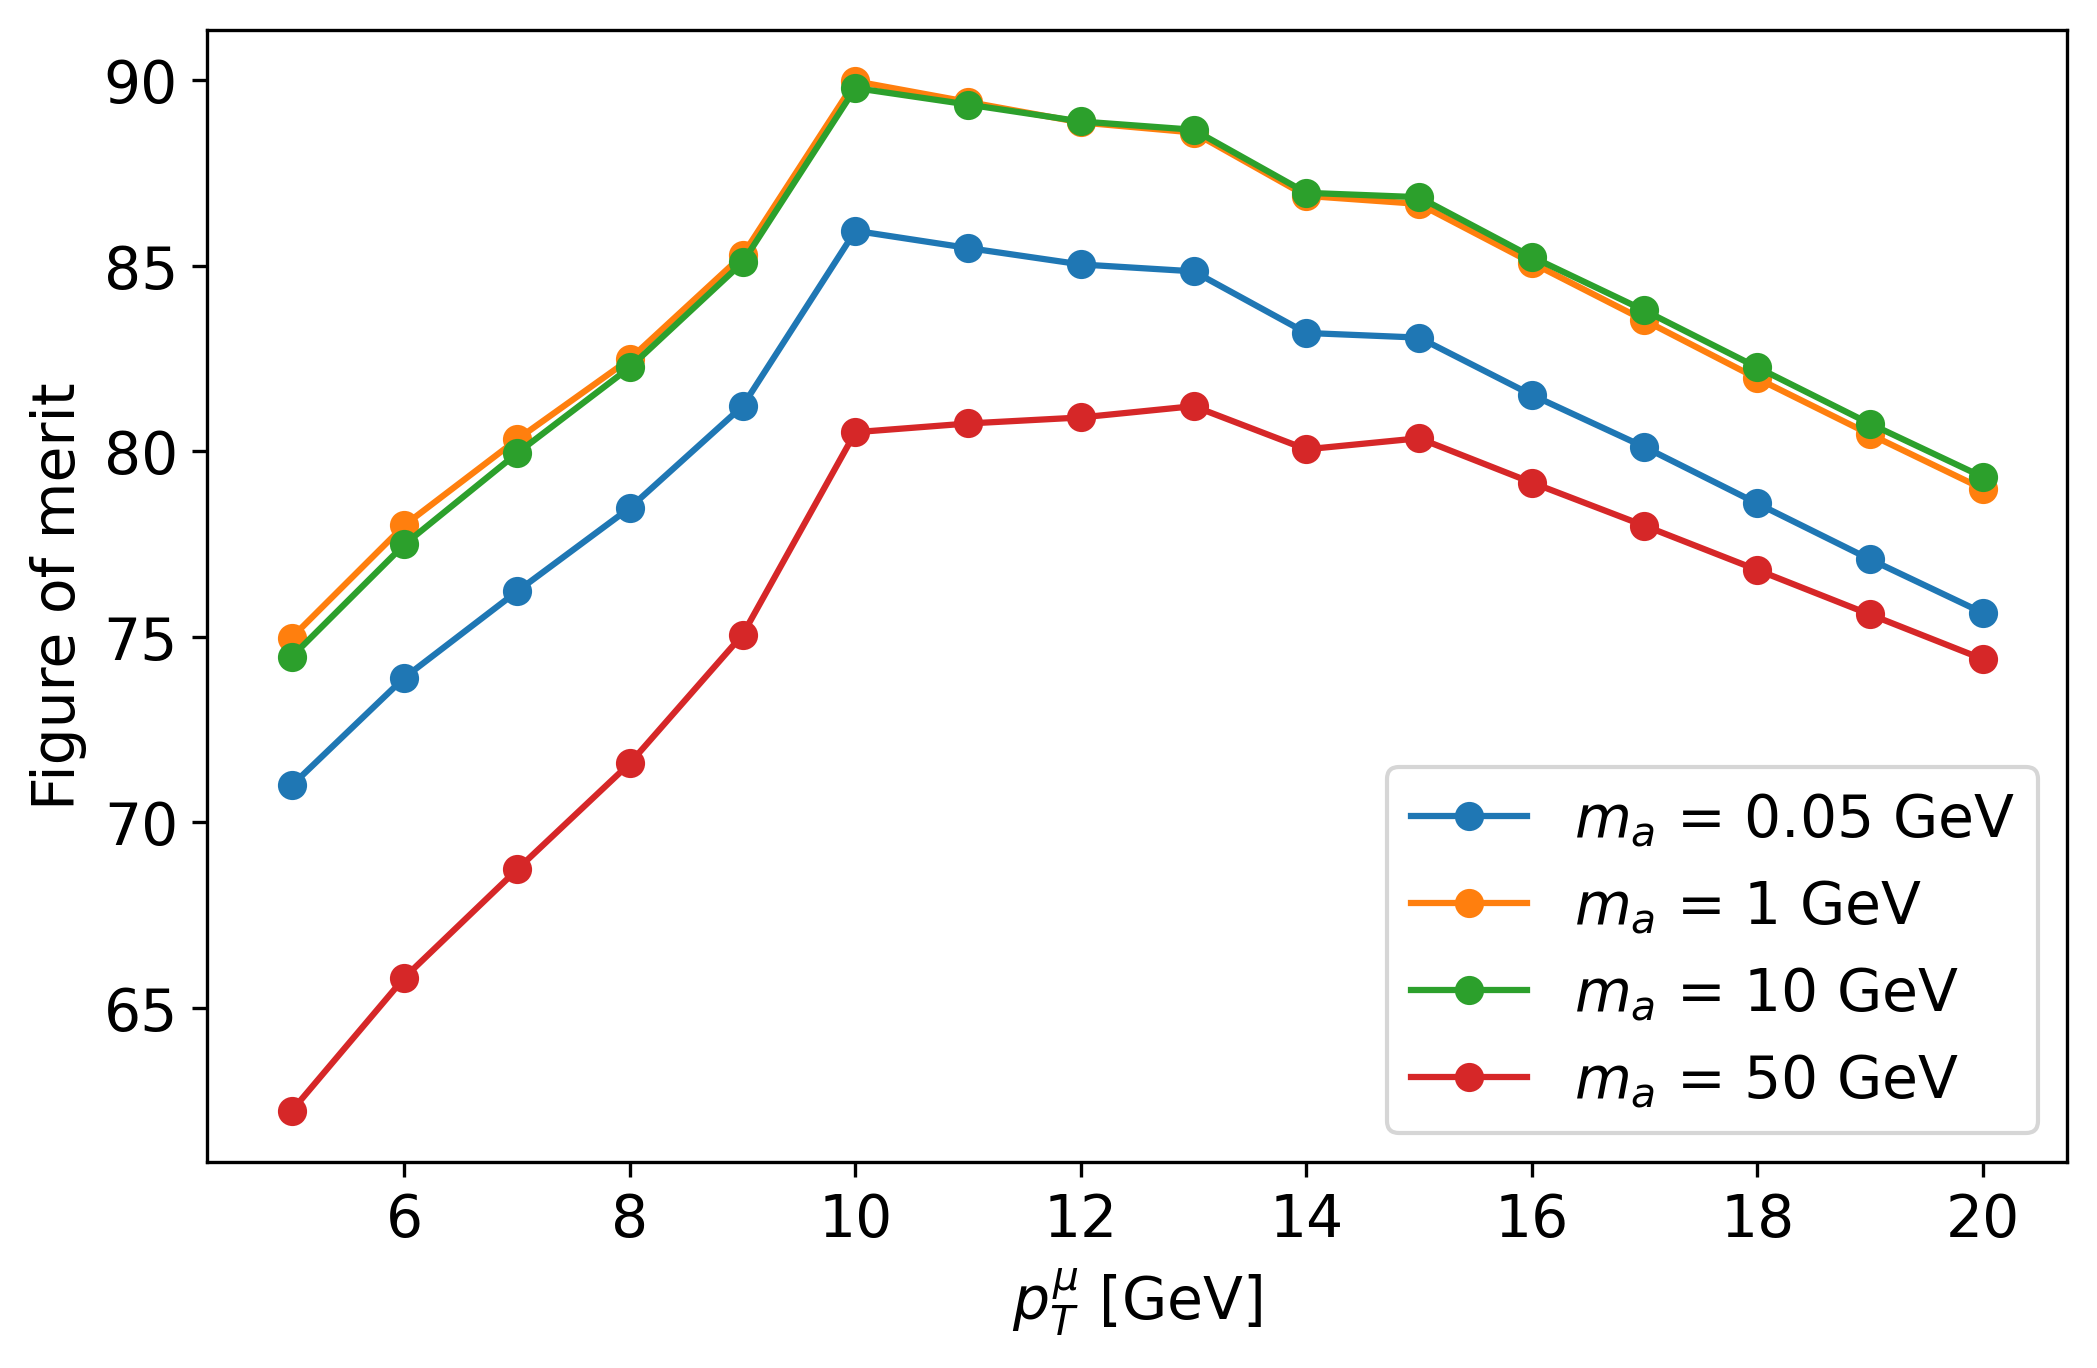

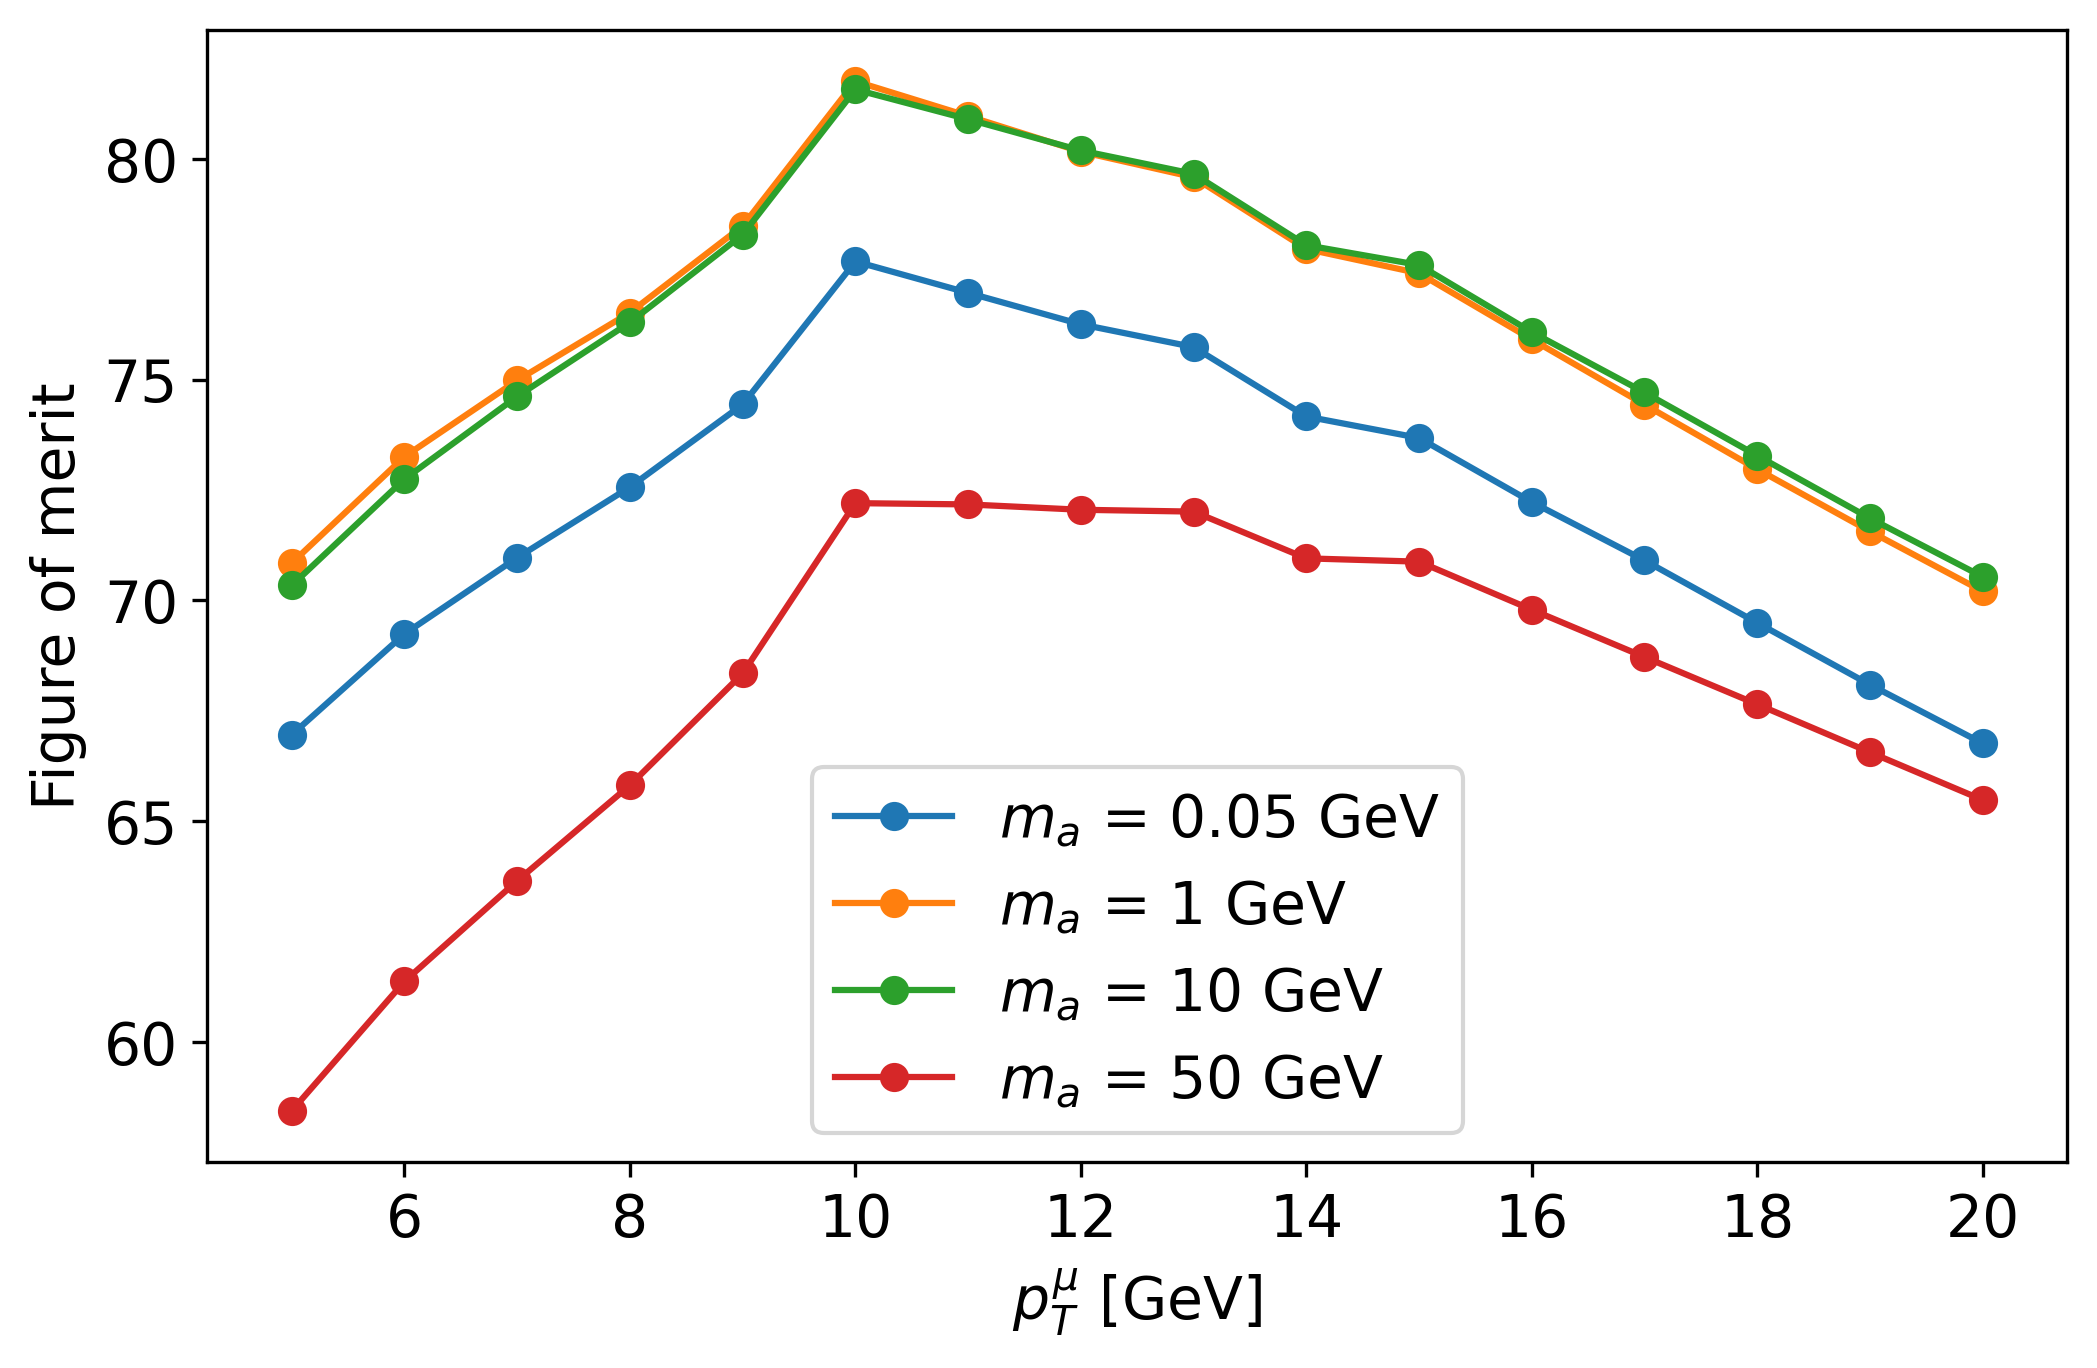

In [11]:
# With only ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_pT)):
    ax.plot(pT_cut,s_pT[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$p_T^{\mu}$ [GeV]")
ax.set_ylabel("Figure of merit")
ax.legend()

# With ttmumu and ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_pT)):
    ax.plot(pT_cut,s_pT_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$p_T^{\mu}$ [GeV]")
ax.set_ylabel("Figure of merit")
ax.legend()

### Muon |eta| cut

In [12]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

print("pT cut: ", 10)
sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
s = get_figure_of_merit(data_inclusive[0],cross_incl[0],N_incl[0],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi)
print("Figure of merit:   ", s)

s_eta_005 = []
s_eta_1 = []
s_eta_10 = []
s_eta_50 = []
s_eta = [s_eta_005, s_eta_1, s_eta_10, s_eta_50]
s_eta_005_bkg = []
s_eta_1_bkg = []
s_eta_10_bkg = []
s_eta_50_bkg = []
s_eta_bkg = [s_eta_005_bkg, s_eta_1_bkg, s_eta_10_bkg, s_eta_50_bkg]

eta_cut = [2.5,2.4,2.3,2.2,2.1,2,1.9,1.8,1.7,1.6,1.5]

for i in range(len(eta_cut)):
    print("eta cut: ", eta_cut[i])
    sel = ((lambda x: abs(x)<eta_cut[i]),"eta", ["muon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    sel = ((lambda x: abs(x)<eta_cut[i]),"eta", ["antimuon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    print(data_inclusive)
    print(data_bkg)
    get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
    get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
    for j in range(len(s_pT)):
        s_eta[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
        s_eta_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlumi))
    print("Figure of merit:   ", s_eta[1][i])

pT cut:  10
[This Dataset contains 71265 events., This Dataset contains 73300 events., This Dataset contains 71898 events., This Dataset contains 81093 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9407.2878648  +-  35.23922016215989
Expected number of events:  10148.571915  +-  37.484605646720276
Expected number of events:  10114.254025919998  +-  37.7203272741165
Expected number of events:  8456.106783915002  +-  29.694688578085216
Expected number of events:  2685.7076150699995  +-  8.995591468597091
Expected number of events:  2480.760827895  +-  93.2986132690755
Figure of merit:    85.94321680670238
eta cut:  2.5
[This Dataset contains 71265 events., This Dataset contains 73300 events., This Dataset contains 71898 events., This Dataset contains 81093 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9407.2878648  +-  35.23922016215989
Expected number of events

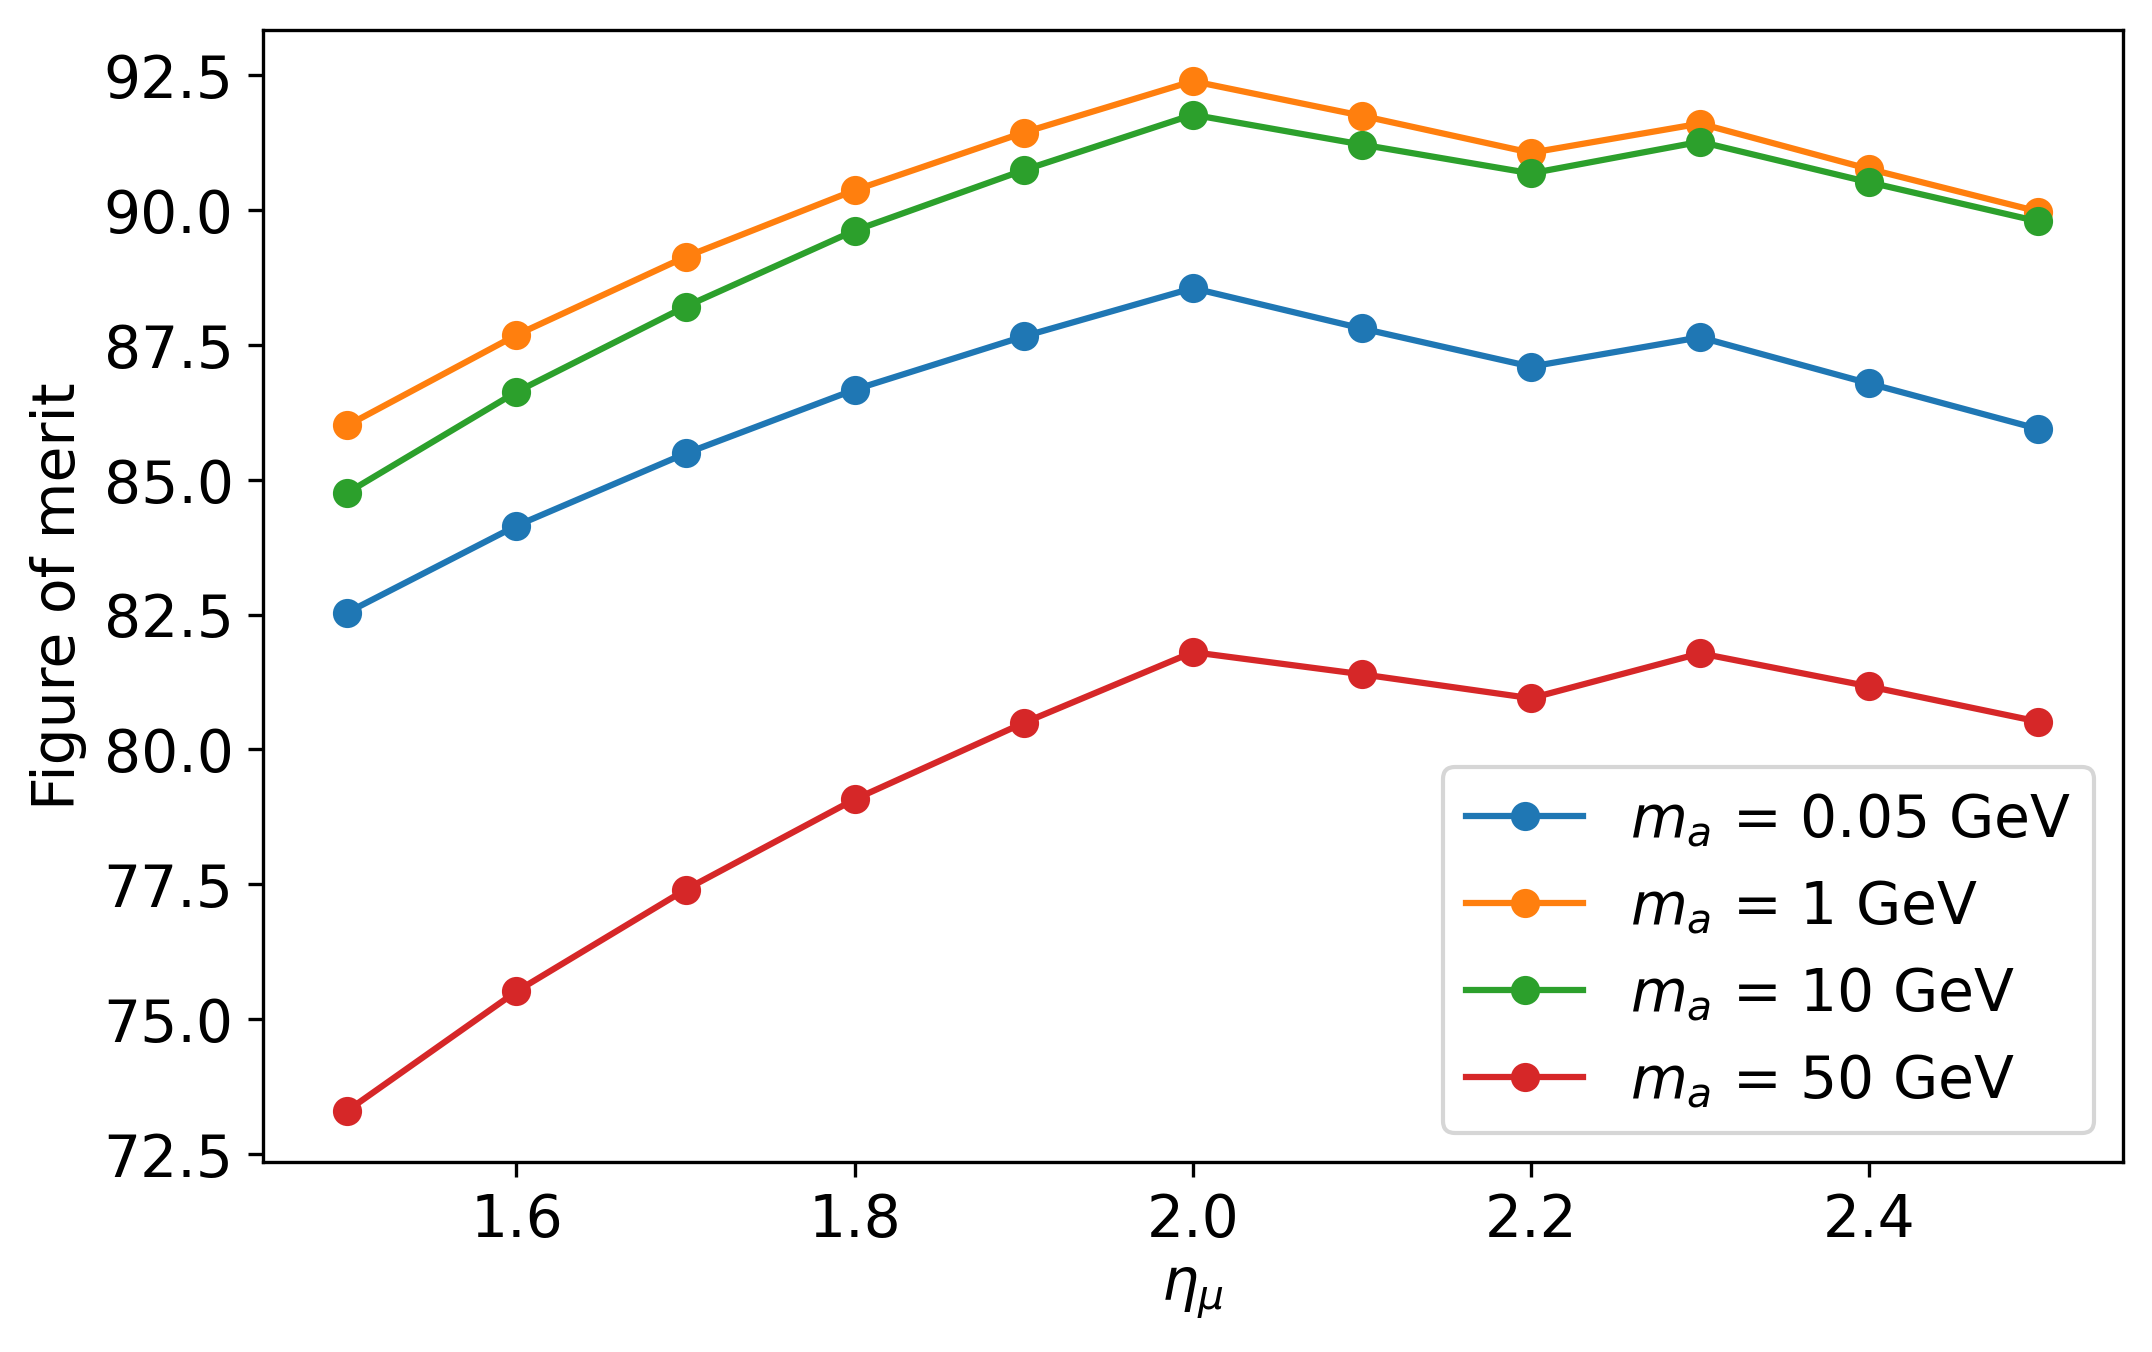

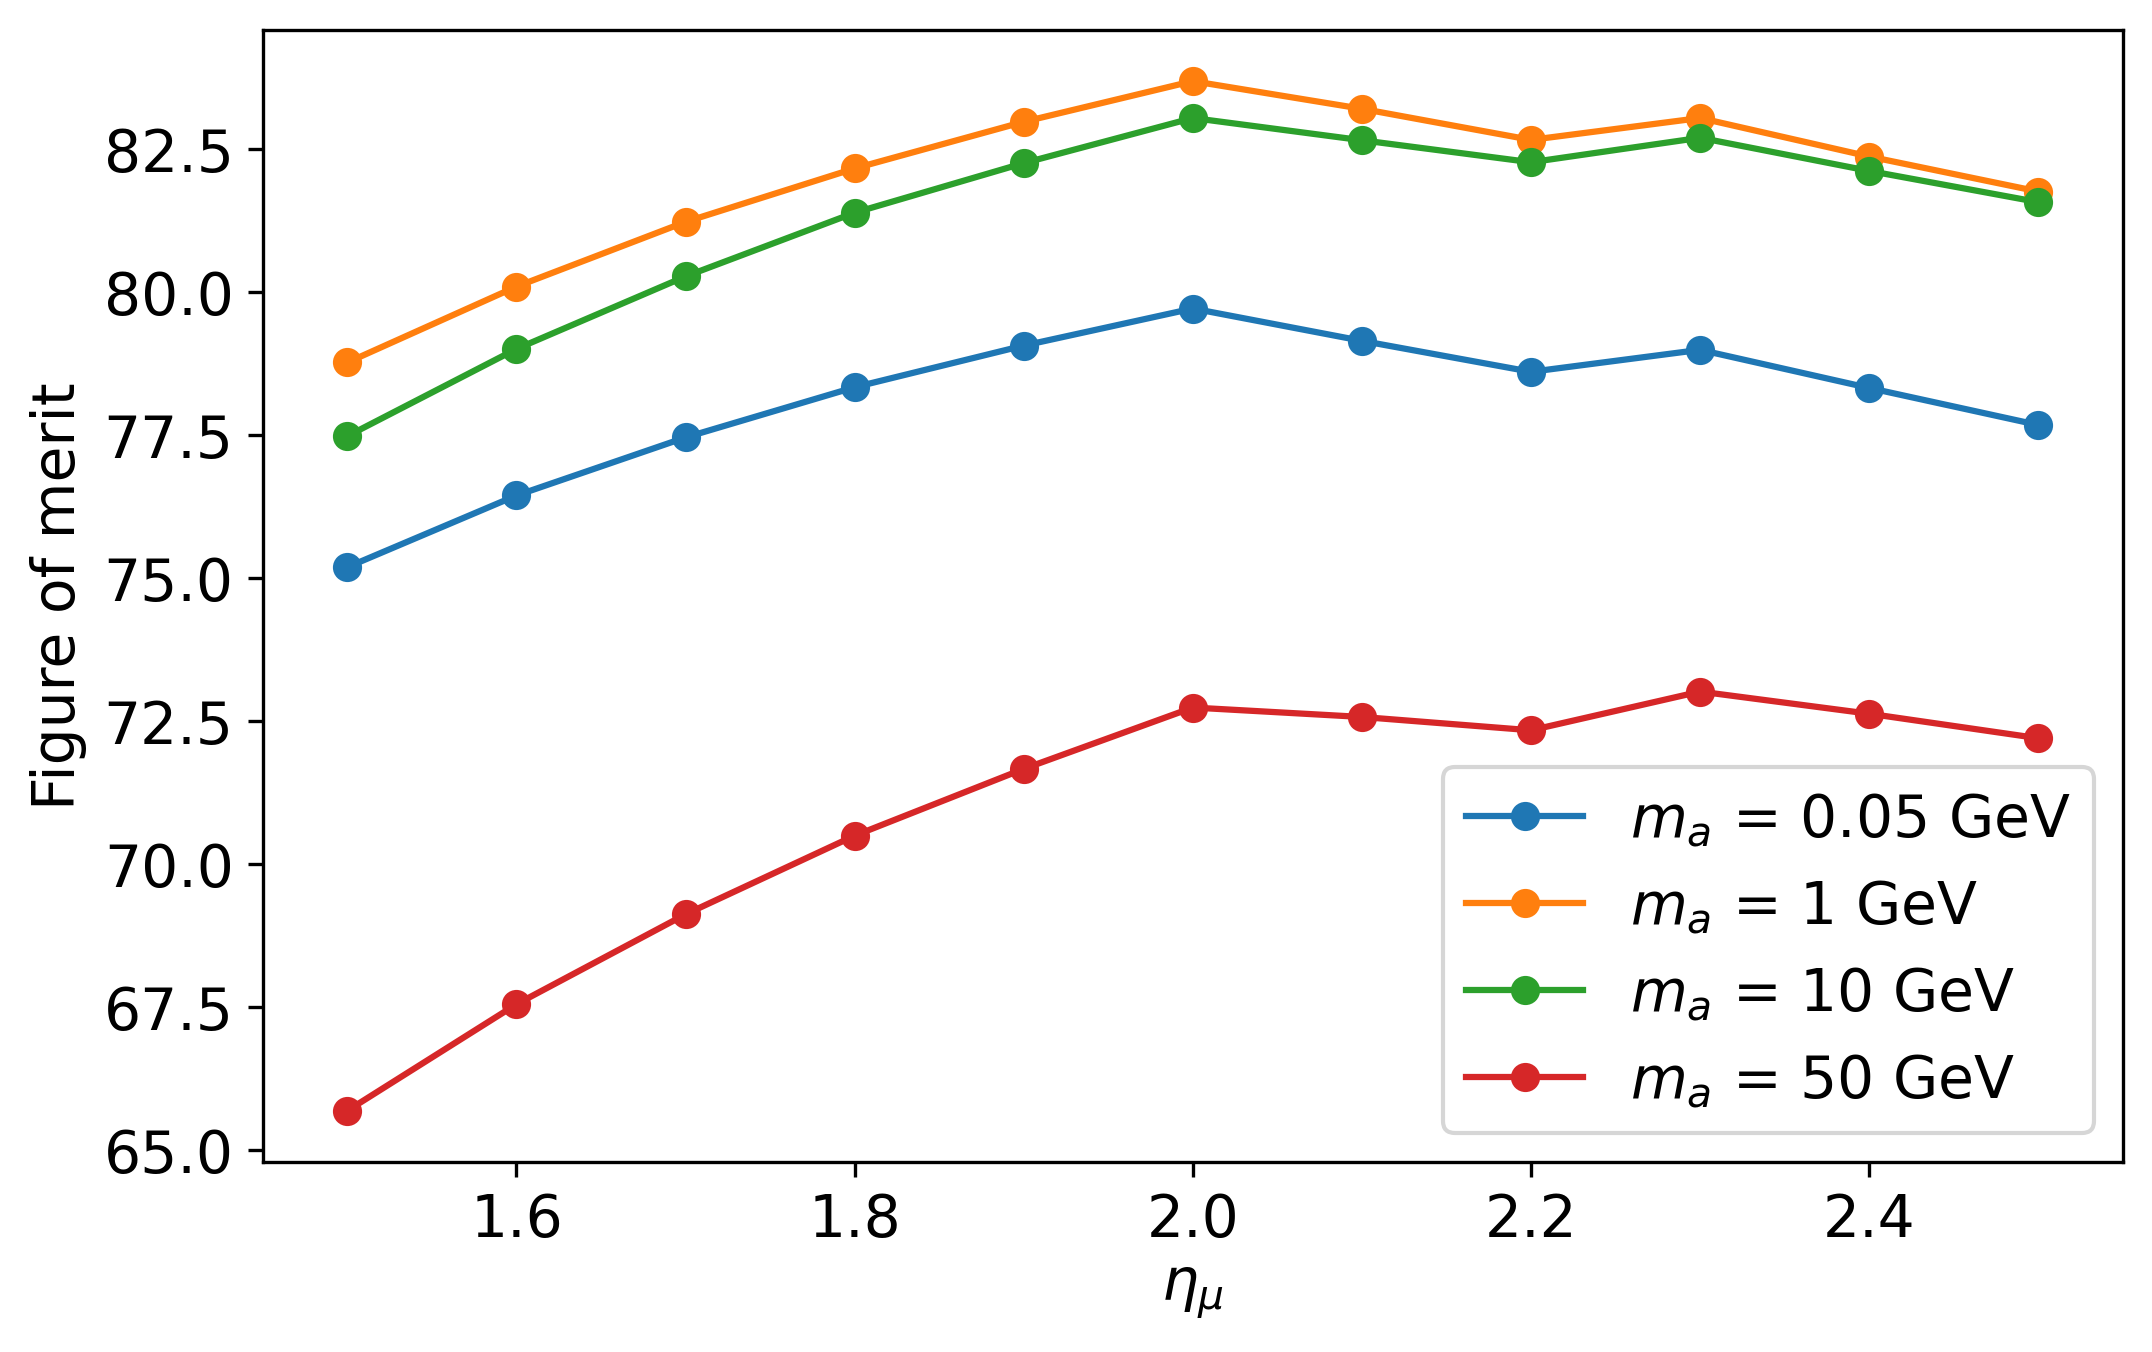

In [13]:
# With only ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(eta_cut,s_eta[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\eta_{\mu}$")
ax.set_ylabel("Figure of merit")
ax.legend()

# With ttmumu and ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(eta_cut,s_eta_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\eta_{\mu}$")
ax.set_ylabel("Figure of merit")
ax.legend()

### Muon DeltaR cut

In [14]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

print("pT cut: ", 10)
sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
s = get_figure_of_merit(data_inclusive[0],cross_incl[0],N_incl[0],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi)
print("Figure of merit:   ", s)

s_deltaR_005 = []
s_deltaR_1 = []
s_deltaR_10 = []
s_deltaR_50 = []
s_deltaR = [s_deltaR_005, s_deltaR_1, s_deltaR_10, s_deltaR_50]
s_deltaR_005_bkg = []
s_deltaR_1_bkg = []
s_deltaR_10_bkg = []
s_deltaR_50_bkg = []
s_deltaR_bkg = [s_deltaR_005_bkg, s_deltaR_1_bkg, s_deltaR_10_bkg, s_deltaR_50_bkg]

deltaR_cut = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]

for i in range(len(deltaR_cut)):
    print("delta R cut: ", deltaR_cut[i])
    sel = ((lambda x: x>deltaR_cut[i]),"deltaR", ["muon","antimuon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    print(data_inclusive)
    print(data_bkg)
    get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
    get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
    for j in range(len(s_pT)):
        s_deltaR[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
        s_deltaR_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlumi))
    print("Figure of merit:   ", s_deltaR[1][i])

pT cut:  10
[This Dataset contains 71265 events., This Dataset contains 73300 events., This Dataset contains 71898 events., This Dataset contains 81093 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9407.2878648  +-  35.23922016215989
Expected number of events:  10148.571915  +-  37.484605646720276
Expected number of events:  10114.254025919998  +-  37.7203272741165
Expected number of events:  8456.106783915002  +-  29.694688578085216
Expected number of events:  2685.7076150699995  +-  8.995591468597091
Expected number of events:  2480.760827895  +-  93.2986132690755
Figure of merit:    85.94321680670238
delta R cut:  0
[This Dataset contains 71265 events., This Dataset contains 73300 events., This Dataset contains 71898 events., This Dataset contains 81093 events.]
[This Dataset contains 89137 events., This Dataset contains 707 events.]
Expected number of events:  9407.2878648  +-  35.23922016215989
Expected number of even

[This Dataset contains 7 events., This Dataset contains 16482 events., This Dataset contains 54178 events., This Dataset contains 78194 events.]
[This Dataset contains 87911 events., This Dataset contains 602 events.]
Expected number of events:  0.92403024  +-  0.3492506027061898
Expected number of events:  2281.9749291  +-  17.774848746753495
Expected number of events:  7621.492317119998  +-  32.74375874224809
Expected number of events:  8153.808761070002  +-  29.15907925696685
Expected number of events:  2648.76810021  +-  8.933514102737977
Expected number of events:  2112.3310019699998  +-  86.09218444433839
Figure of merit:    34.09200675241733
delta R cut:  1.3
[This Dataset contains 7 events., This Dataset contains 14246 events., This Dataset contains 52684 events., This Dataset contains 77810 events.]
[This Dataset contains 87707 events., This Dataset contains 506 events.]
Expected number of events:  0.92403024  +-  0.3492506027061898
Expected number of events:  1972.39502729999

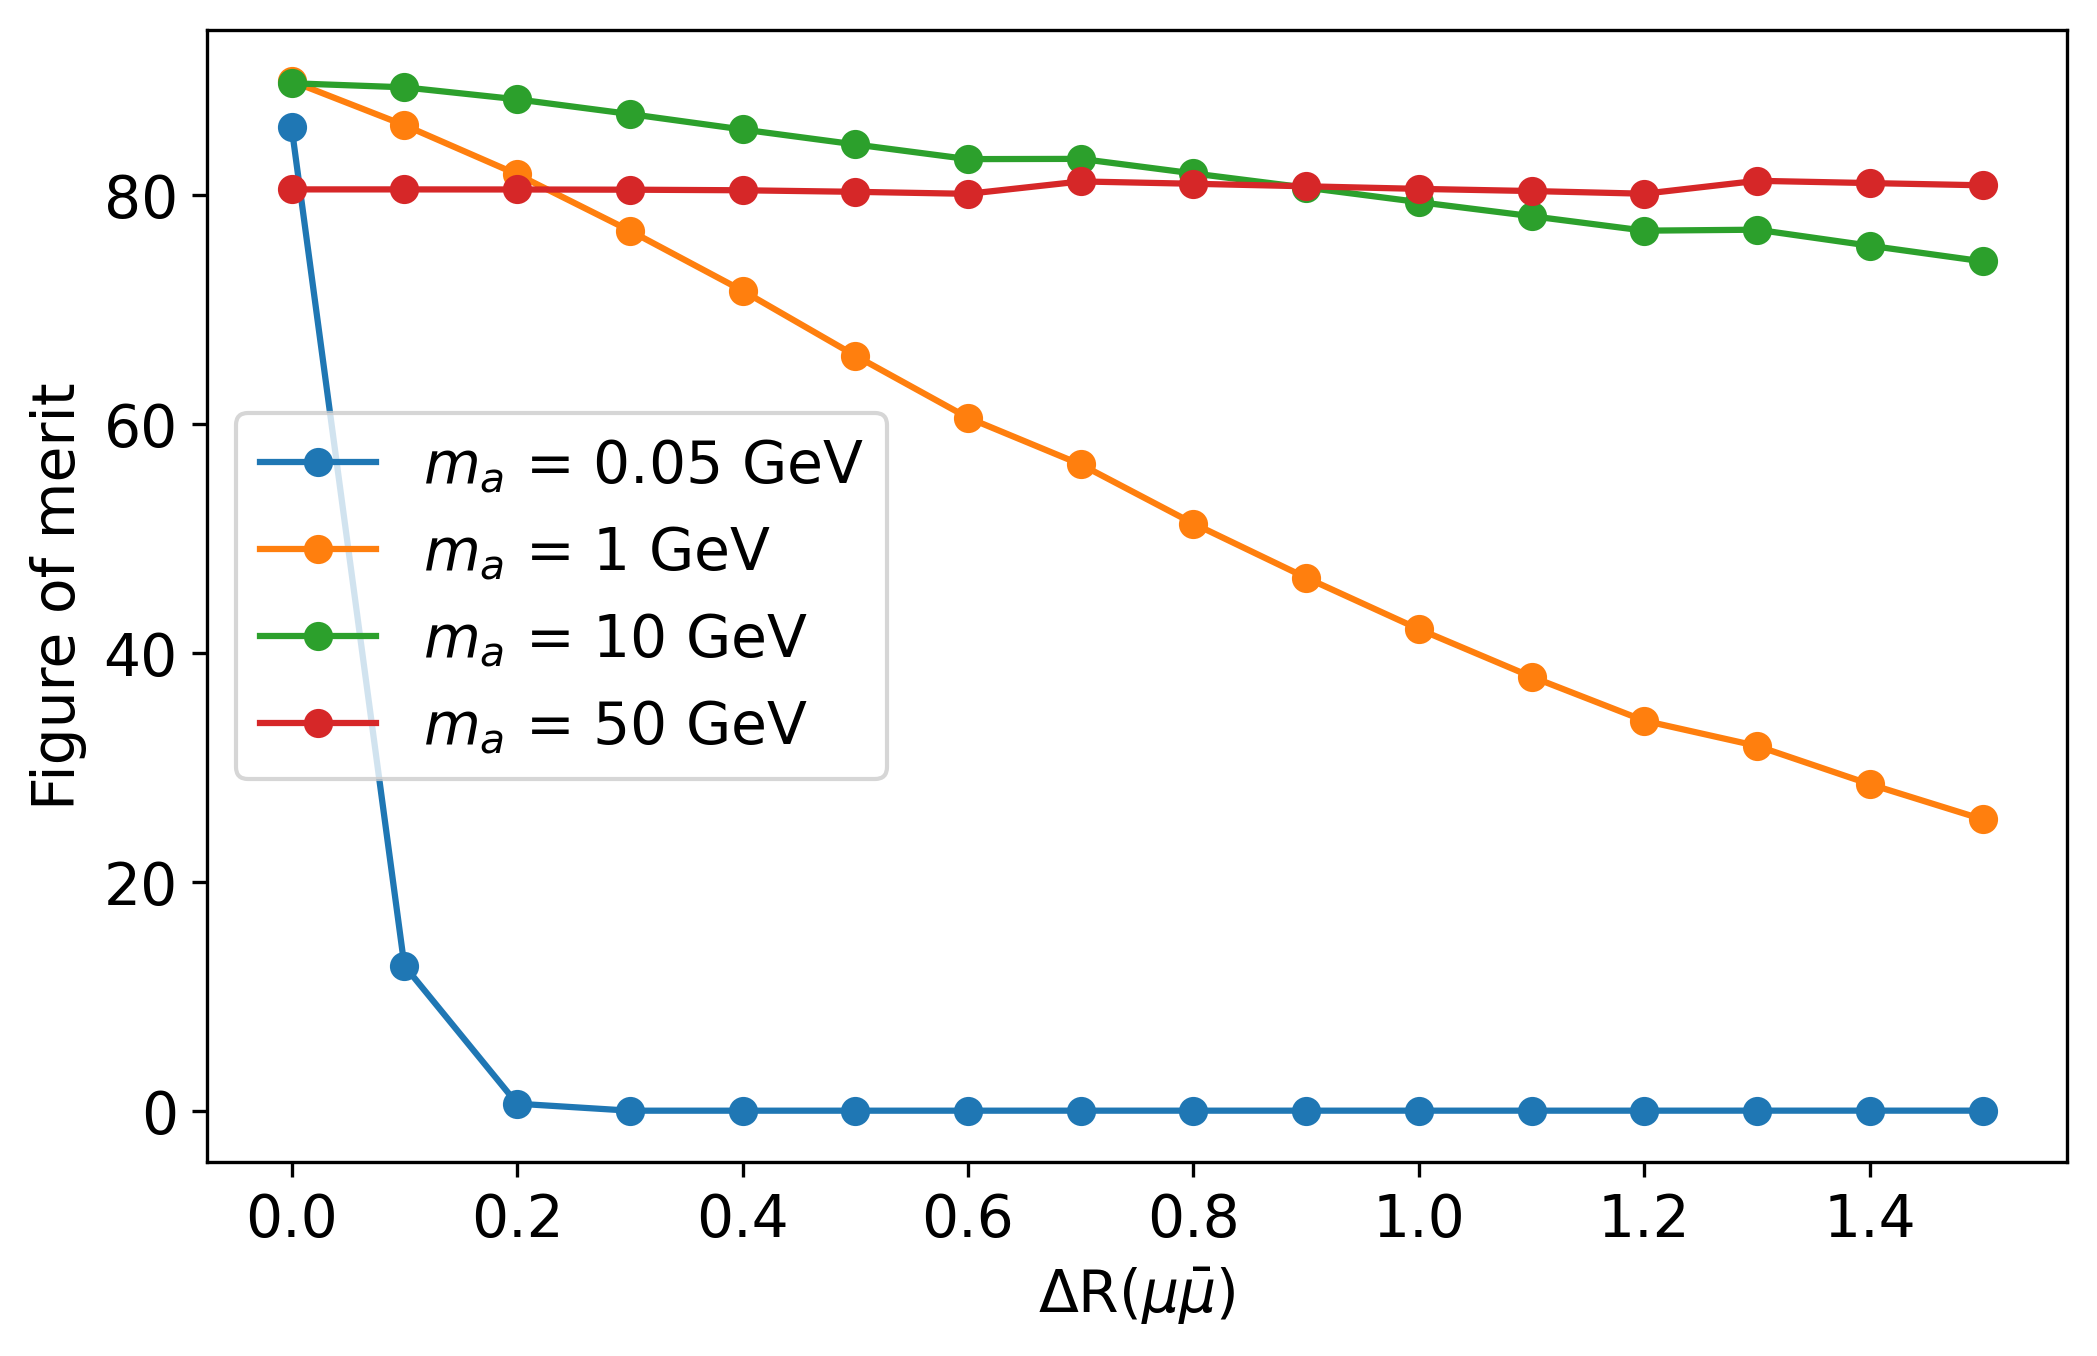

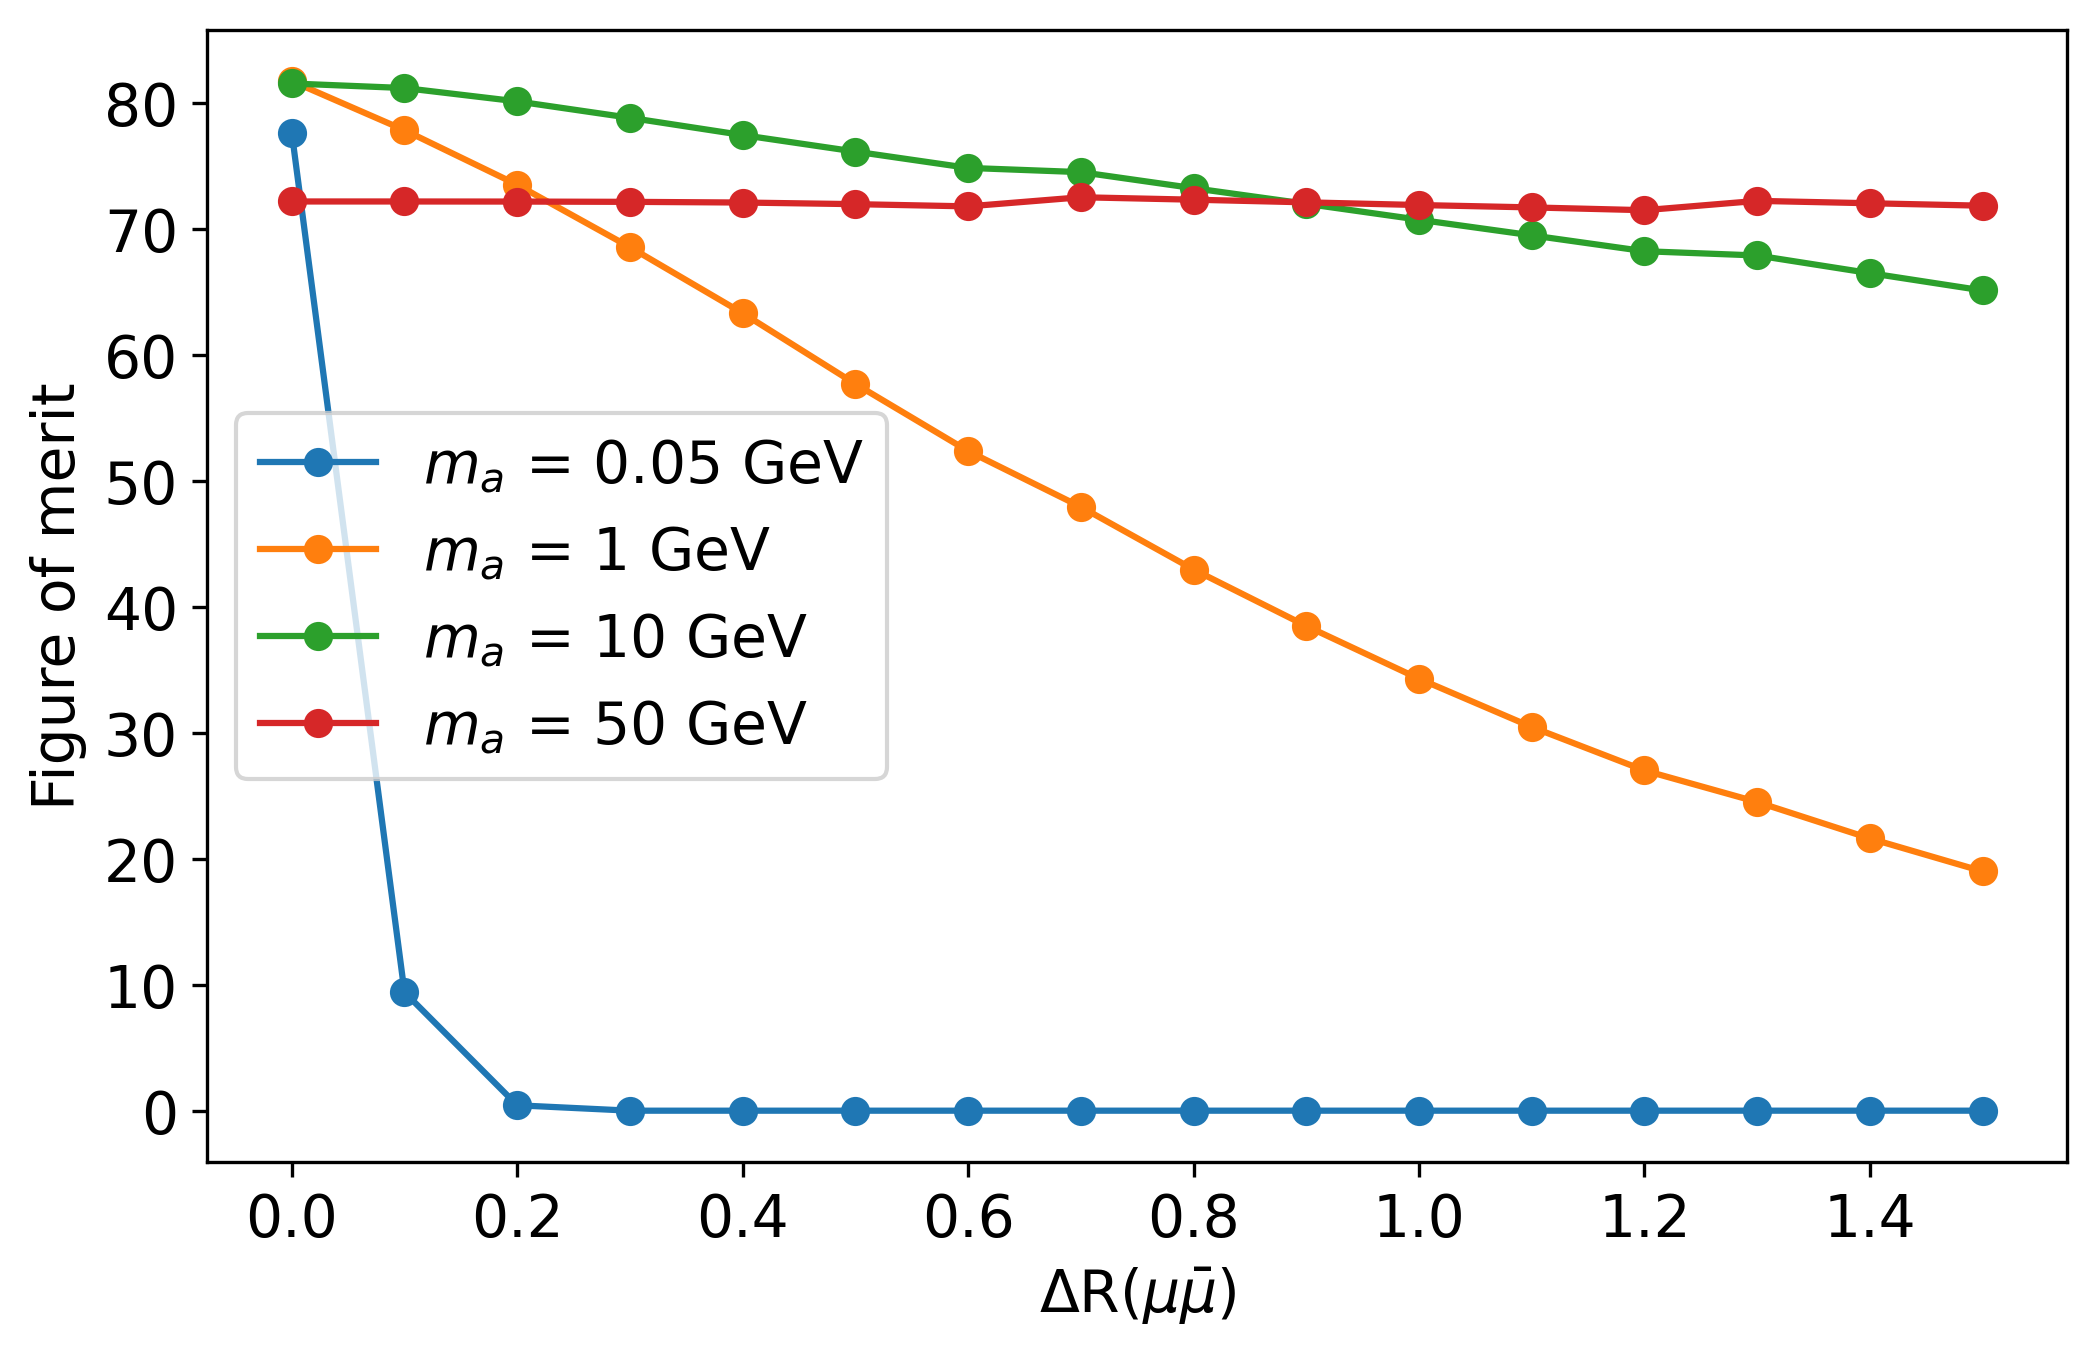

In [15]:
# With only ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(deltaR_cut,s_deltaR[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\Delta$R($\mu\bar{\mu}$)")
ax.set_ylabel("Figure of merit")
ax.legend()

# With ttmumu and ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(deltaR_cut,s_deltaR_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\Delta$R($\mu\bar{\mu}$)")
ax.set_ylabel("Figure of merit")
ax.legend()

In [16]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

print("pT cut: ", 10)
sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print("eta cut: ", 2.0)
sel = ((lambda x: abs(x)<2.0),"eta", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: abs(x)<10),"eta", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

print(data_inclusive)
print(data_bkg)
get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
s = get_figure_of_merit(data_inclusive[0],cross_incl[0],N_incl[0],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi)
print("Figure of merit:   ", s)

s_deltaR2_005 = []
s_deltaR2_1 = []
s_deltaR2_10 = []
s_deltaR2_50 = []
s_deltaR2 = [s_deltaR2_005, s_deltaR2_1, s_deltaR2_3, s_deltaR2_10, s_deltaR2_50, s_deltaR2_100]
s_deltaR2_005_bkg = []
s_deltaR2_1_bkg = []
s_deltaR2_3_bkg = []
s_deltaR2_10_bkg = []
s_deltaR2_50_bkg = []
s_deltaR2_100_bkg = []
s_deltaR2_bkg = [s_deltaR2_005_bkg, s_deltaR2_1_bkg, s_deltaR2_3_bkg, s_deltaR2_10_bkg, s_deltaR2_50_bkg, s_deltaR2_100_bkg]

deltaR_cut = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]

for i in range(len(deltaR_cut)):
    print("delta R cut: ", deltaR_cut[i])
    sel = ((lambda x: x>deltaR_cut[i]),"deltaR", ["muon","antimuon"])
    data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
    data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
    print(data_inclusive)
    print(data_bkg)
    get_expected_events(data_inclusive, cross_incl, intlumi, N_incl)
    get_expected_events(data_bkg, cross_bkg, intlumi, N_bkg)
    for j in range(len(s_pT)):
        s_deltaR2[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlumi))
        s_deltaR2_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlumi))
    print("Figure of merit:   ", s_deltaR2[1][i])

pT cut:  10
eta cut:  2.0
[This Dataset contains 67444 events., This Dataset contains 69485 events., This Dataset contains 68430 events., This Dataset contains 77127 events.]
[This Dataset contains 83213 events., This Dataset contains 327 events.]
Expected number of events:  8902.899358080002  +-  34.28149903069857
Expected number of events:  9620.375436749999  +-  36.496102684744315
Expected number of events:  9626.392987199997  +-  36.7993643767128
Expected number of events:  8042.545570185003  +-  28.95945009394964
Expected number of events:  2507.2168434299997  +-  8.691531469562696
Expected number of events:  1147.3957435949999  +-  63.45112960680029
Figure of merit:    88.52693694791647


NameError: name 's_deltaR2_3' is not defined

In [ ]:
# With only ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(deltaR_cut,s_deltaR2[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\Delta$R($\mu\bar{\mu}$)")
ax.set_ylabel("Figure of merit")
ax.legend()

# With ttmumu and ttj background
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(deltaR_cut,s_deltaR2_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\Delta$R($\mu\bar{\mu}$)")
ax.set_ylabel("Figure of merit")
ax.legend()

# Figure of merit depending on integrated luminosity

In [ ]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

print("pT cut: ", 10)
sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

s_intlum_005 = []
s_intlum_1 = []
s_intlum_3 = []
s_intlum_10 = []
s_intlum_50 = []
s_intlum_100 = []
s_intlum = [s_intlum_005, s_intlum_1, s_intlum_3, s_intlum_10, s_intlum_50, s_intlum_100]
s_intlum_005_bkg = []
s_intlum_1_bkg = []
s_intlum_3_bkg = []
s_intlum_10_bkg = []
s_intlum_50_bkg = []
s_intlum_100_bkg = []
s_intlum_bkg = [s_intlum_005_bkg, s_intlum_1_bkg, s_intlum_3_bkg, s_intlum_10_bkg, s_intlum_50_bkg, s_intlum_100_bkg]

intlum_fb = [150,200,250,300,350,400,500]
intlum = []
for il in intlum_fb:
    intlum.append(il*1000)

for i in range(len(intlum)):
    get_expected_events(data_inclusive, cross_incl, intlum[i], N_incl)
    get_expected_events(data_bkg, cross_bkg, intlum[i], N_bkg)
    
    for j in range(len(s_pT)):
        s_intlum[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlum[i]))
        s_intlum_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlum[i]))
    print("Figure of merit:   ", s_intlum[1][i])

In [ ]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(intlum_fb,s_intlum[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\mathcal{L}_{int}$ [$fb^{-1}$]")
ax.set_ylabel("Figure of merit")
ax.legend()

fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(intlum_fb,s_intlum_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\mathcal{L}_{int}$ [$fb^{-1}$]")
ax.set_ylabel("Figure of merit")
ax.legend()

In [ ]:
#Resetting the data
data_inclusive = data_inclusive_org
data_bkg = data_bkg_org
cross_incl = cross_incl_org
cross_bkg = cross_bkg_org
N_incl = N_incl_org
N_bkg = N_bkg_org
masses = masses_org

print("pT cut: ", 10)
sel = ((lambda x: x>10),"pT", ["muon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]
sel = ((lambda x: x>10),"pT", ["antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

sel = ((lambda x: x>0.2),"deltaR", ["muon","antimuon"])
data_inclusive = [dc.Dataset.event_selection(ds,sel) for ds in data_inclusive]
data_bkg = [dc.Dataset.event_selection(ds,sel) for ds in data_bkg]

s_intlum_005 = []
s_intlum_1 = []
s_intlum_3 = []
s_intlum_10 = []
s_intlum_50 = []
s_intlum_100 = []
s_intlum = [s_intlum_005, s_intlum_1, s_intlum_3, s_intlum_10, s_intlum_50, s_intlum_100]
s_intlum_005_bkg = []
s_intlum_1_bkg = []
s_intlum_3_bkg = []
s_intlum_10_bkg = []
s_intlum_50_bkg = []
s_intlum_100_bkg = []
s_intlum_bkg = [s_intlum_005_bkg, s_intlum_1_bkg, s_intlum_3_bkg, s_intlum_10_bkg, s_intlum_50_bkg, s_intlum_100_bkg]

intlum_fb = [150,200,250,300,350,400,500]
intlum = []
for il in intlum_fb:
    intlum.append(il*1000)

for i in range(len(intlum)):
    get_expected_events(data_inclusive, cross_incl, intlum[i], N_incl)
    get_expected_events(data_bkg, cross_bkg, intlum[i], N_bkg)
    
    for j in range(len(s_pT)):
        s_intlum[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],[data_bkg[1]],[cross_bkg[1]],[N_bkg[1]],intlum[i]))
        s_intlum_bkg[j].append(get_figure_of_merit(data_inclusive[j],cross_incl[j],N_incl[j],data_bkg,cross_bkg,N_bkg,intlum[i]))
    print("Figure of merit:   ", s_intlum[1][i])

In [ ]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(intlum_fb,s_intlum[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\mathcal{L}_{int}$ [$fb^{-1}$]")
ax.set_ylabel("Figure of merit")
ax.legend()

fig, ax = plt.subplots()  # Create a figure containing a single axes.
for i in range(len(s_eta)):
    ax.plot(intlum_fb,s_intlum_bkg[i], 'o-',label=r"$m_a$ = "+str(masses[i])+" GeV")
ax.set_xlabel(r"$\mathcal{L}_{int}$ [$fb^{-1}$]")
ax.set_ylabel("Figure of merit")
ax.legend()